# Continous Control

This is the main interface file corresponding to the Navigation exercise. Here, all of the plots and checkpoints are generated.

Contents:
* [Imports](#first-bullet)
* [Set up environment](#second-bullet)
* [Set up training functions](#third-bullet)
* [Results](#fourth-bullet)

## 1 - Imports<a class="anchor" id="first-bullet"></a>
In this subsection, we import the relevant source code and UnityEngine. We also import auxiliarry imports which are useful for us.

In [1]:
import src as ContinousControl
import numpy as np
from src.agent import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import os
from collections import deque

In [2]:
import sys
DRL_LOCATION = os.environ['_DRL_LOCATION_']
sys.path.insert(0,DRL_LOCATION)
from unityagents import UnityEnvironment
REACHER_LOCATION = os.environ['_REACHER_LOCATION_']

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import numpy as np
import os

import warnings
warnings.filterwarnings("ignore")

## 2 - Set up environment<a class="anchor" id="second-bullet"></a>
Here we set up the environment from UnityEngine. However, we wrap this around our bespoke environment wrapper in order to make 'env' behave more like the OpenAI environments.

In [3]:
_env_ = UnityEnvironment(file_name=REACHER_LOCATION)
env = ContinousControl.Environment(_env_)

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


## 3 - Set up training functions<a class="anchor" id="third-bullet"></a>
In this section we set up the relevant functions for training

In [4]:
def date_and_time(with_time = False):
    """
    Returns a YYYYMMDD string with out without time
    
    Params
    ======
        with_time (boolean) : Gives time in string is True, does not otherwise.
    """
    import datetime
    
    YEAR = str(datetime.datetime.today().year)
    
    MONTH = str(0) + str(datetime.datetime.today().month) if datetime.datetime.today().month < 10 \
    else str(datetime.datetime.today().month)
    
    DAY = str(0) + str(datetime.datetime.today().day) if datetime.datetime.today().day < 10 \
    else str(datetime.datetime.today().day)
    
    HOUR = str(0) + str(datetime.datetime.today().hour) if datetime.datetime.today().hour < 10\
    else str(datetime.datetime.today().hour)
    
    MINUTE = str(0) + str(datetime.datetime.today().minute) if datetime.datetime.today().minute < 10\
    else str(datetime.datetime.today().minute)
    
    if with_time:
        return YEAR+MONTH+DAY+'_'+HOUR+MINUTE
    else:
        return YEAR+MONTH+DAY
    
    

        
def if_folder_not_there_create(folder_destination):
    """Creates a folder if it does not exist
    
    Params
    ======
        folder_destination (string) : The path to be created if it does not already exist.
    """
    if not os.path.exists(folder_destination):
        os.makedirs(folder_destination)
        
def folder_number(path):
    """Creates a folder of the form run_# in case we have multiple runs per day
    
    Params
    ======
        path (string) : The path to be created if it does not already exist.
    """

    folders = []

    # r=root, d=directories, f = files
    for r, d, f in os.walk(path):
        for folder in d:
            folders.append(os.path.join(r, folder))

    numbers = []
    for f in folders:
        ff = f.split('_')
        numbers.append(ff[-1])

    if len(numbers) == 0:
        new_folder = "run"+"_1"
    else:
        m = int(numbers[-1])
        new_folder = "run"+"_"+str(m+1)

    if_folder_not_there_create(path + "//" +new_folder)  
    return new_folder

In [5]:
def write_to_json(data, filename):
    import json
    with open(filename, "w") as write_file:
        json.dump(data, write_file)
        
def json_to_dict(filename):
    import json
    with open(filename, "r") as read_file:
        data = json.load(read_file)
    return data

def plot(scores, ma_scores, folder):
    ax = plt.subplots(figsize=(20, 10))
    plt.plot(np.arange(len(scores)), scores,label = 'Scores')
    plt.plot(np.arange(len(scores)), ma_scores, label = 'Moving average scores')
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.legend(loc='upper left')
    plt.savefig(folder)
    plt.show()

In [6]:
def run(data, policy, agent, winning_maximum = 30.0, number_of_episodes = 500, \
        stop_at_goal = True, folder = 'PPO', how_often_to_print = 10):
    """Runs the training algorithm
    
    Params
    ======
        data (dictionary) : The hyperparameter data
        policy ([nn.Module]) : The network used for training
        agent (Agent type) : The agent
        winning_maximum (float) : The return obtained for the task deemed successful
        number_of_episodes (int) : nmber of episodes to consider per trajectory
        stop_at_goal (boolean) : True if algorithm should stop once the winning_maximum is reached
        folder (string) : Folder location
    """
    
    all_scores = []
    averages = []
    solved_in = None
    scores = deque(maxlen=100)
    
    date_and_time_string = date_and_time()
    folder_destination = "results/"+folder + "/" + date_and_time_string
    
    if_folder_not_there_create(folder_destination)
    new_folder = folder_number(folder_destination)
    
    folder_destination = folder_destination+"//"+new_folder
        
    write_to_json(data, folder_destination + "/data.json")

    for i_episode in range(number_of_episodes):
        agent.step()
        last_mean_reward = ContinousControl.get_mean_score(env, policy)
        last_average = np.mean(np.array(all_scores[-100:])) if len(all_scores) > 100 else np.mean(np.array(all_scores))
        all_scores.append(last_mean_reward)
        averages.append(last_average)
        
        if i_episode%how_often_to_print==0:
            print('Episode: {} Total score this episode: {} Last {} average: {}'.format(i_episode + 1, \
                                                                    last_mean_reward, min(i_episode + 1, 100), last_average))

        if last_average >= winning_maximum:
            torch.save(policy.state_dict(), folder_destination+"/checkpoint_solved.pth")
            solved_in = i_episode-100
            print('Episode: {} Total score this episode: {} Last {} average: {}'.format(i_episode + 1, \
                                                                last_mean_reward, min(i_episode + 1, 100), last_average))
            if stop_at_goal: break

    plot(all_scores, averages, folder_destination+"/plot.png")
    torch.save(policy.state_dict(), folder_destination+"/checkpoint_not_solved.pth")
    return all_scores, averages, solved_in

## 4 - Results<a class="anchor" id="fourth-bullet"></a>

This is the main section where the results a computed and displayed. We consider two main policy gradient algorithms:

    - Asynchronous VPG
    - Asynchronous PPO with GAE


We produce plots for each of these cases, which can be seen by scrolling down through the intermeddiate results of each run.



### 4a - PPO

In [7]:
# Increase font size of plt plots for aesthetic convenience.
plt.rcParams.update({'font.size': 22})

Episode: 1 Total score this episode: 1.095999975502491 Last 1 average: nan
Episode: 11 Total score this episode: 1.8099999595433474 Last 11 average: 1.422349968208
Episode: 21 Total score this episode: 3.0339999321848152 Last 21 average: 1.8575999584794043
Episode: 31 Total score this episode: 3.8904999130405487 Last 31 average: 2.371499946992844
Episode: 41 Total score this episode: 5.496999877132476 Last 41 average: 2.927649934561923
Episode: 51 Total score this episode: 8.222499816212803 Last 51 average: 3.721589916815981
Episode: 61 Total score this episode: 10.60149976303801 Last 61 average: 4.65017489606049
Episode: 71 Total score this episode: 13.656499694753439 Last 71 average: 5.701221301139199
Episode: 81 Total score this episode: 16.92749962164089 Last 81 average: 6.838074847157114
Episode: 91 Total score this episode: 20.393499544169753 Last 91 average: 8.121322040696525
Episode: 101 Total score this episode: 23.971999464184044 Last 100 average: 9.527479787044227
Episode: 1

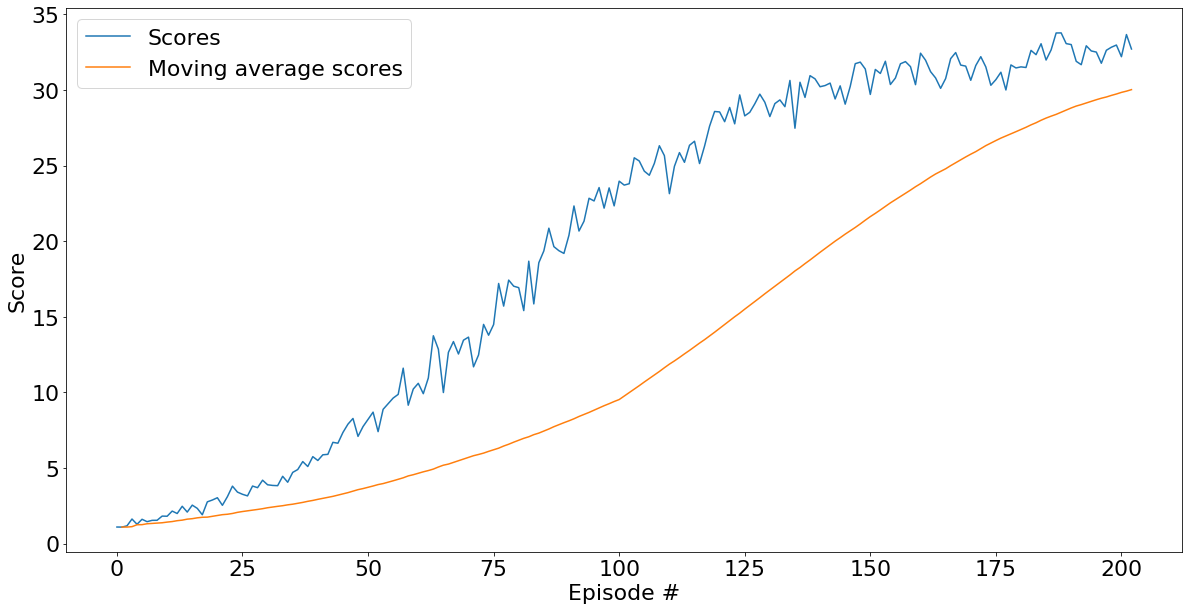

In [11]:
# We define data to be consumed by the PPO agent and its components.
data = {'state_size' : 33,
'action_size' : 4,
'hidden_size' : [512],
'adam_lr' : 3e-4,
'adam_eps' : 1e-5,
'learner_epochs' : 10,
'ppo_clip' : 0.2,
'gradient_clip' : 5,
'trajectory_length' : 2048,
'number_of_agents' : 20,
'discount_rate' : 0.99,
'GAE_lambda' : 0.95}

#Define a policy, in this case the ActorCritic model
policy = ContinousControl.ActorCritic(data['state_size'], data['action_size'], data['hidden_size'], device)

#Define an optimiser
optimiser = optim.Adam(policy.parameters(),data['adam_lr'],eps= data['adam_eps'])

#Define a learner, in this case the PPO. It takes the Actor-Critic and optimiser as input.
learner = ContinousControl.ProximalPolicyOptimisation(policy, optimiser, data['learner_epochs'], \
                                                      ppo_clip = data['ppo_clip'], \
                                                      gradient_clip = data['gradient_clip'])

#Define a trajectory, in this case the advantage function collector.
trajectory = ContinousControl.trajectories_advantage(policy, data['trajectory_length'], data['number_of_agents'], \
                                                     data['discount_rate'], data['GAE_lambda'])
#Define the PPOAgent, which takes as input the trajectory and learner, thus encapuslates all the information we
#need.
agent = ContinousControl.PPOAgent(env, trajectory, learner)

all_scores, averages, solved_in = \
run(data, policy, agent,winning_maximum = 30.0, number_of_episodes = 500,stop_at_goal = True, folder = 'PPO',\
    how_often_to_print = 10)

### 4b - VPG

Episode: 1 Total score this episode: 0.8924999800510705 Last 1 average: nan
Episode: 101 Total score this episode: 3.124999930150807 Last 100 average: 2.2772199491001666
Episode: 201 Total score this episode: 3.644999918527901 Last 100 average: 3.6644799180924896


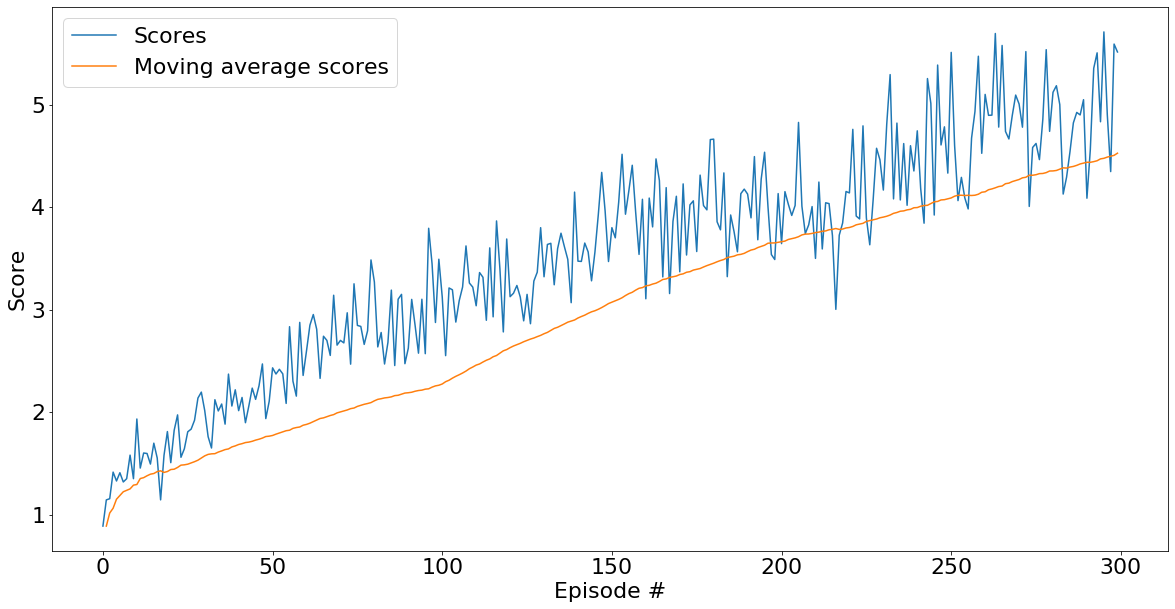

In [8]:
# We define data to be consumed by the VPG agent and its components.
data = {'state_size' : 33,
'action_size' : 4,
'hidden_size' : [512],
'adam_lr' : 3e-4,
'adam_eps' : 1e-5,
'learner_epochs' : 10,
'trajectory_length' : 2048,
'number_of_agents' : 20,
'discount_rate' : 0.99,}

#Define a policy, in this case the VPG model.
policy = ContinousControl.PolicyMod(data['state_size'], data['action_size'], data['hidden_size'], device)

#Define an optimiser.
optimiser = optim.Adam(policy.parameters(),data['adam_lr'],eps= data['adam_eps'])

#Define a trajectory, in this case the returns function collector,note that it takes the policy as input.
trajectory = ContinousControl.trajectories_returns(policy, data['trajectory_length'], data['number_of_agents'], \
                                                     data['discount_rate'])

#Define a learner, in this case the VPG which takes the optimiser and trajectory as input.
learner = ContinousControl.VanillaPolicyGradientOptimisation(optimiser, data['learner_epochs'], trajectory)

#Define the agent, which only now needs the learner function which encapsulated everything else.
agent = ContinousControl.VPGAgent(env, learner)

all_scores, averages, solved_in = \
run(data, policy, agent,winning_maximum = 30.0, number_of_episodes = 300,stop_at_goal = True, folder = 'VPG',\
    how_often_to_print = 100)

In [ ]:
env.close()